<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/04_Paper_Graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Benchmark Analysis
## 04 - Visualization and Analysis of Benchmark Results

### Exploring the dichotomy between knowledge degradation and reasoning improvement
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** CPU (no GPU required)

**Estimated Runtime:** ~5 minutes
## Objective
This notebook loads the complete evaluation results for the Llama-3.2-1B model from `llama_1b_complete_results_latest.json`.

The primary goal is to visualize the impact of pruning, using the **`expansion_rate`** as the primary independent variable (X-axis). We will explore the "capability trade-off" hypothesis: identifying which benchmarks degrade ("Fragile Capabilities") and which remain robust or even improve ("Robust Capabilities") as the expansion rate is reduced.

In [1]:
# === 1. Setup & Imports ===

# Install necessary libraries
!pip install pandas matplotlib seaborn

# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure plots for better readability
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [8]:
# === 2. Load Data ===

# Download json files from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_1b_complete_results_latest.json
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_3b_complete_results_latest.json

# Verify download
import os
if os.path.exists('llama_1b_complete_results_latest.json'):
    print("✅ llama_1b_complete_results_latest.json downloaded successfully")
else:
    print("❌ Failed to download llama_1b_complete_results_latest.json")

# Load the JSON data
try:
    file_path_1b = 'llama_1b_complete_results_latest.json' # Define file_path here
    with open(file_path_1b, 'r') as f:
        data1b = json.load(f)
    file_path_3b = 'llama_3b_complete_results_latest.json' # Define file_path here
    with open(file_path_3b, 'r') as f:
        data3b = json.load(f)
    print("File loaded successfully into 'data' variable.")
except Exception as e:
    print(f"ERROR: Could not read or parse JSON file. {e}")
    data = None

# Check if both data variables were successfully loaded
if data1b and data3b:
    # Store 'models_evaluated' from each file in a dictionary
    models_data = {
        '1B': data1b['models_evaluated'],
        '3B': data3b['models_evaluated']
    }
    print("✅ 'models_data' created successfully with data from both 1B and 3B files.")

    # You can now access data like this:
    # print(json.dumps(models_data['1B']['baseline'], indent=2))
    # print(json.dumps(models_data['3B']['baseline'], indent=2))

else:
    print("❌ Could not create 'models_data' as one or both JSON files failed to load.")

✅ llama_1b_complete_results_latest.json downloaded successfully
File loaded successfully into 'data' variable.
✅ 'models_data' created successfully with data from both 1B and 3B files.


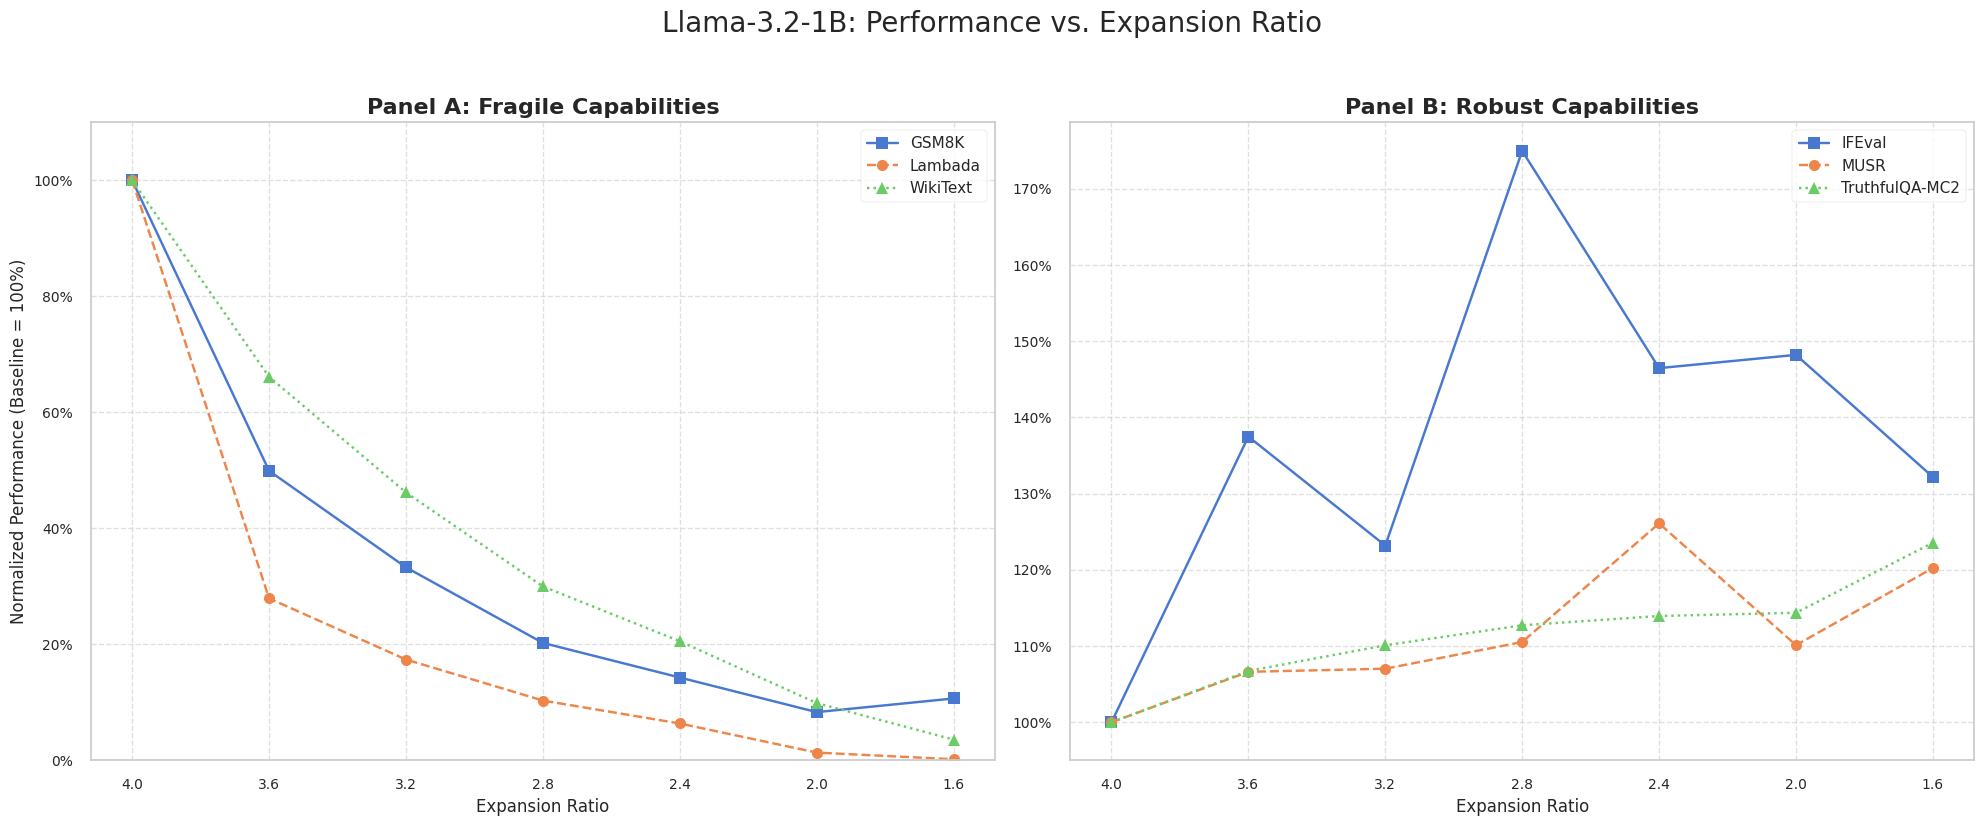

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. Setup ---
plt.style.use('seaborn-v0_8-notebook')
metrics_to_extract = {
    'GSM8K': ('gsm8k', 'exact_match,strict-match', 'higher_is_better'),
    'Lambada': ('lambada_openai', 'perplexity', 'lower_is_better'),
    'WikiText': ('wikitext', 'word_perplexity,none', 'lower_is_better'),
    'IFEval': ('ifeval', 'prompt_level_strict_acc,none', 'higher_is_better'),
    'MUSR': ('leaderboard_musr', 'acc_norm,none', 'higher_is_better'),
    'TruthfulQA-MC2': ('truthfulqa_mc2', 'accuracy', 'higher_is_better'),
}

# --- 2. Data Extraction and Transformation (1B) ---
if 'models_data' in locals() and '1B' in models_data:
    processed_data = []
    for model_name, model_data in models_data['1B'].items():
        row = {
            'model_name': model_name,
            'pruning_pct': model_data['pruning_pct'],
            'expansion_rate': model_data['expansion_rate']
        }
        for label, (bench, key, mtype) in metrics_to_extract.items():
            try:
                row[label] = model_data['results'][bench][key]
            except KeyError:
                row[label] = None
        processed_data.append(row)

    df = pd.DataFrame(processed_data)
    df = df.sort_values(by='pruning_pct').reset_index(drop=True)

    # *** CHANGE: Get the exact expansion rates for the X-axis ***
    x_ticks = df['expansion_rate'].tolist()

    # --- 3. Normalization ---
    baseline = df.iloc[0]
    for label, (bench, key, mtype) in metrics_to_extract.items():
        norm_col = f"{label}_norm"
        baseline_val = baseline[label]
        if mtype == 'higher_is_better':
            df[norm_col] = (df[label] / baseline_val) * 100
        elif mtype == 'lower_is_better':
            df[norm_col] = (baseline_val / df[label]) * 100

    # --- 4. Plotting (UPDATED for 1B) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    # --- Panel A: Fragile Capabilities ---
    panel_a_metrics = {'GSM8K': ('GSM8K_norm', 's-'), 'Lambada': ('Lambada_norm', 'o--'), 'WikiText': ('WikiText_norm', '^:')}
    for label, (col, style) in panel_a_metrics.items():
        ax1.plot(df['expansion_rate'], df[col], style, label=label, markersize=8)
    ax1.set_title('Panel A: Fragile Capabilities', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Expansion Ratio', fontsize=12)
    ax1.set_ylabel('Normalized Performance (Baseline = 100%)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.invert_xaxis()

    # *** CHANGE: Set exact X-axis ticks ***
    ax1.set_xticks(x_ticks)

    ax1.set_ylim(0, 110)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

    # --- Panel B: Robust Capabilities ---
    panel_b_metrics = {'IFEval': ('IFEval_norm', 's-'), 'MUSR': ('MUSR_norm', 'o--'), 'TruthfulQA-MC2': ('TruthfulQA-MC2_norm', '^:')}
    for label, (col, style) in panel_b_metrics.items():
        ax2.plot(df['expansion_rate'], df[col], style, label=label, markersize=8)

    #ax2.axhline(y=100, color='red', linestyle='--', label='Baseline Performance') # Baseline line

    ax2.set_title('Panel B: Robust Capabilities', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Expansion Ratio', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.invert_xaxis()

    # *** CHANGE: Set exact X-axis ticks ***
    ax2.set_xticks(x_ticks)

    ax2.set_ylim(bottom=95)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

    # --- Global Plot Settings ---
    fig.suptitle('Llama-3.2-1B: Performance vs. Expansion Ratio', fontsize=20, y=1.03)
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: 'models_data' variable not found or does not contain '1B' key.")

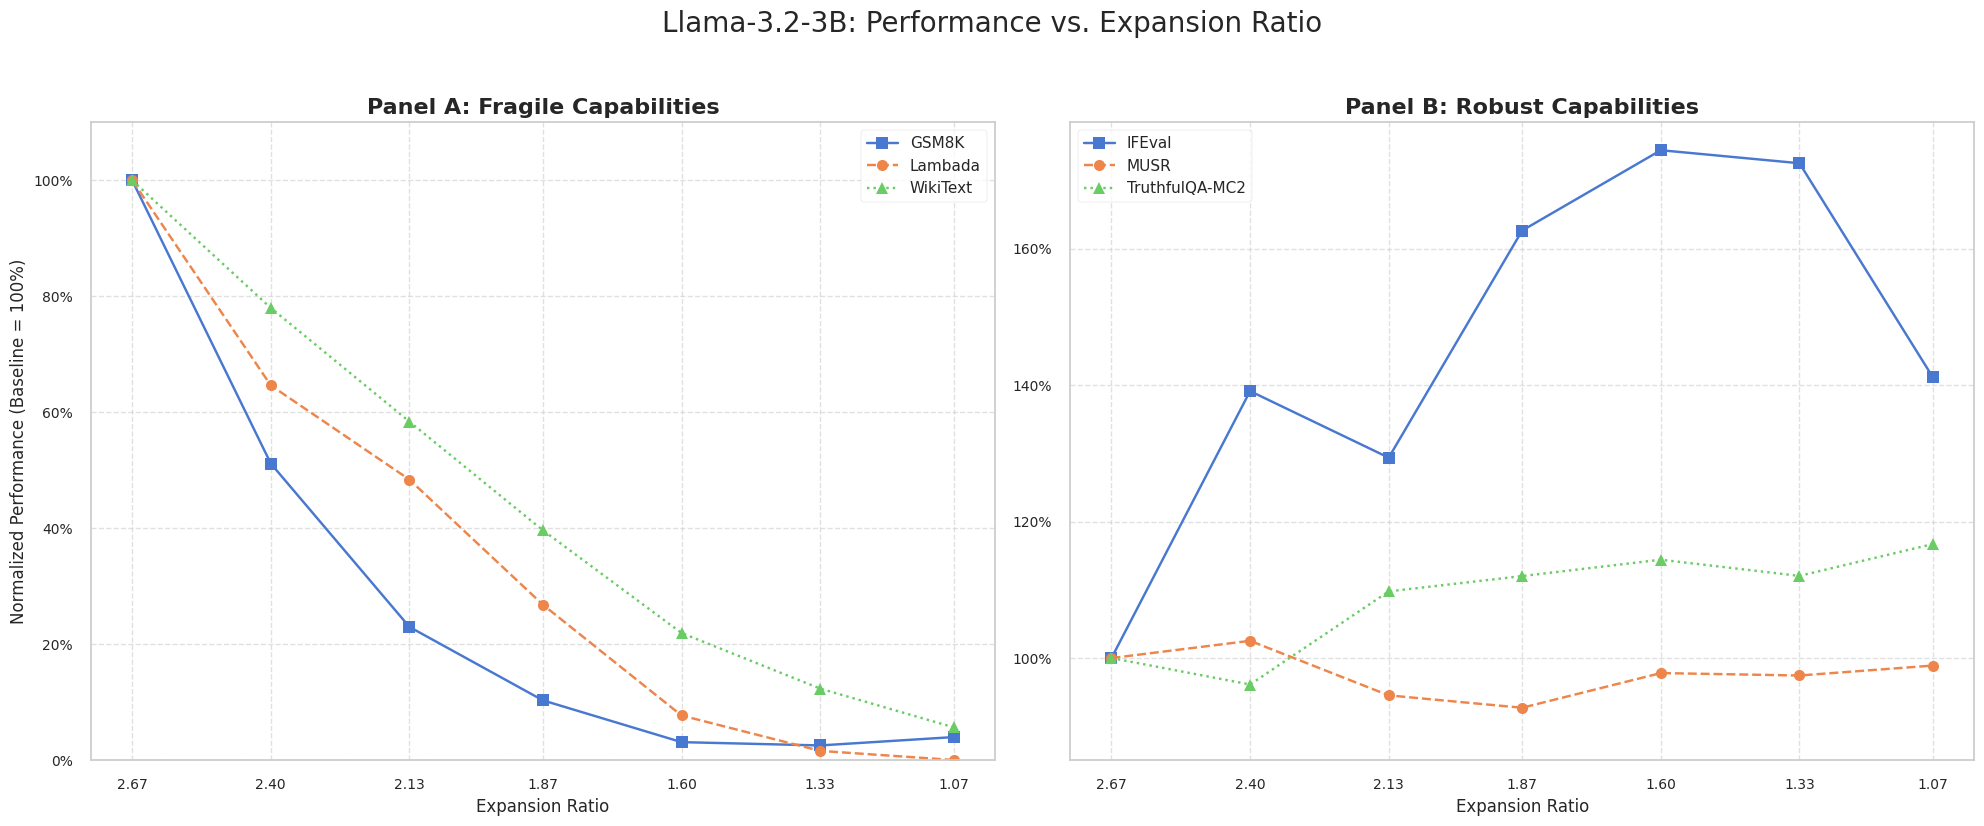

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. Setup ---
plt.style.use('seaborn-v0_8-notebook')
metrics_to_extract = {
    'GSM8K': ('gsm8k', 'exact_match,strict-match', 'higher_is_better'),
    'Lambada': ('lambada_openai', 'perplexity', 'lower_is_better'),
    'WikiText': ('wikitext', 'word_perplexity,none', 'lower_is_better'),
    'IFEval': ('ifeval', 'prompt_level_strict_acc,none', 'higher_is_better'),
    'MUSR': ('leaderboard_musr', 'acc_norm,none', 'higher_is_better'),
    'TruthfulQA-MC2': ('truthfulqa_mc2', 'accuracy', 'higher_is_better'),
}

# --- 2. Data Extraction and Transformation (3B) ---
if 'models_data' in locals() and '3B' in models_data:
    processed_data = []
    for model_name, model_data in models_data['3B'].items():
        row = {
            'model_name': model_name,
            'pruning_pct': model_data['pruning_pct'],
            'expansion_rate': model_data['expansion_rate']
        }
        for label, (bench, key, mtype) in metrics_to_extract.items():
            try:
                row[label] = model_data['results'][bench][key]
            except KeyError:
                row[label] = None
        processed_data.append(row)

    df = pd.DataFrame(processed_data)
    df = df.sort_values(by='pruning_pct').reset_index(drop=True)

    # *** CHANGE: Get the exact expansion rates for the X-axis ***
    x_ticks = df['expansion_rate'].tolist()

    # --- 3. Normalization ---
    baseline = df.iloc[0]
    for label, (bench, key, mtype) in metrics_to_extract.items():
        norm_col = f"{label}_norm"
        baseline_val = baseline[label]
        if mtype == 'higher_is_better':
            df[norm_col] = (df[label] / baseline_val) * 100
        elif mtype == 'lower_is_better':
            df[norm_col] = (baseline_val / df[label]) * 100

    # --- 4. Plotting (UPDATED for 3B) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    # --- Panel A: Fragile Capabilities ---
    panel_a_metrics = {'GSM8K': ('GSM8K_norm', 's-'), 'Lambada': ('Lambada_norm', 'o--'), 'WikiText': ('WikiText_norm', '^:')}
    for label, (col, style) in panel_a_metrics.items():
        ax1.plot(df['expansion_rate'], df[col], style, label=label, markersize=8)
    ax1.set_title('Panel A: Fragile Capabilities', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Expansion Ratio', fontsize=12)
    ax1.set_ylabel('Normalized Performance (Baseline = 100%)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.invert_xaxis()

    # *** CHANGE: Set exact X-axis ticks ***
    ax1.set_xticks(x_ticks)

    ax1.set_ylim(0, 110)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

    # --- Panel B: Robust Capabilities ---
    panel_b_metrics = {'IFEval': ('IFEval_norm', 's-'), 'MUSR': ('MUSR_norm', 'o--'), 'TruthfulQA-MC2': ('TruthfulQA-MC2_norm', '^:')}
    for label, (col, style) in panel_b_metrics.items():
        ax2.plot(df['expansion_rate'], df[col], style, label=label, markersize=8)
    ax2.set_title('Panel B: Robust Capabilities', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Expansion Ratio', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.invert_xaxis()

    # *** CHANGE: Set exact X-axis ticks ***
    ax2.set_xticks(x_ticks)

    ax2.set_ylim(bottom=85)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

    # --- Global Plot Settings ---
    fig.suptitle('Llama-3.2-3B: Performance vs. Expansion Ratio', fontsize=20, y=1.03)
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: 'models_data' variable not found or does not contain '3B' key.")

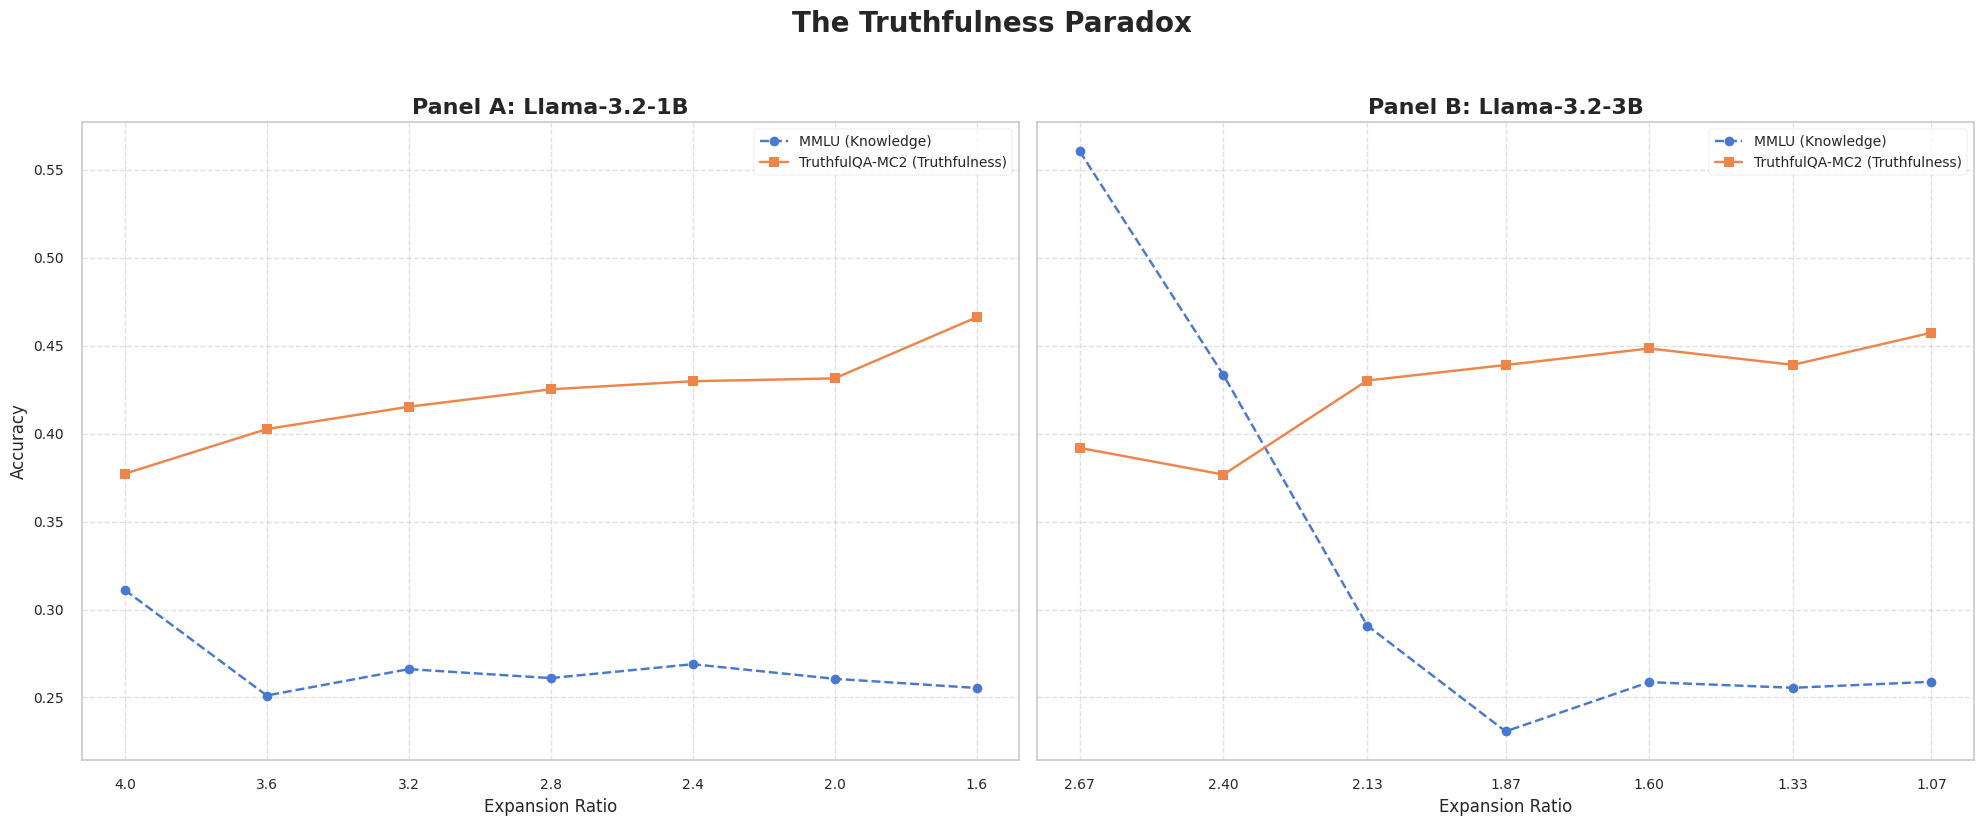


Graph 'figure_truthfulness_paradox.png' saved successfully.


In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- FUNCIÓN (Sin cambios, ya extrae los datos que necesitamos) ---
def extract_paradox_data(model_eval_dict):
    """
    Extracts MMLU and TruthfulQA-MC2 data from a
    pre-loaded 'models_evaluated' dictionary.
    """
    results_list = []

    for model_key, model_data in model_eval_dict.items():
        try:
            expansion_rate = model_data['expansion_rate']
            mmlu_acc = model_data['results']['mmlu']['accuracy']
            tqa_mc2_acc = model_data['results']['truthfulqa_mc2']['accuracy']

            results_list.append({
                'expansion_rate': expansion_rate,
                'MMLU': mmlu_acc,
                'TruthfulQA_MC2': tqa_mc2_acc
            })
        except KeyError as e:
            print(f"Warning: Missing data in {model_key}. Error: {e}")

    df = pd.DataFrame(results_list)
    df = df.sort_values(by='expansion_rate', ascending=False)
    return df

# --- Carga y Procesamiento de Datos (Sin cambios) ---

if 'models_data' in locals() and '1B' in models_data and '3B' in models_data:

    df_1b = extract_paradox_data(models_data['1B'])
    df_3b = extract_paradox_data(models_data['3B'])

    # --- Creación del Gráfico (ESTILO ADAPTADO) ---

    # *** CHANGE: Use the 'notebook' style from the first plots ***
    plt.style.use('seaborn-v0_8-notebook')

    # *** CHANGE: Use figsize from the first plots ***
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True) # sharey=True es bueno aquí

    # --- Panel A: Llama-3.2-1B ---
    # *** CHANGE: Updated labels to English ***
    ax1.plot(df_1b['expansion_rate'], df_1b['MMLU'],
             marker='o', linestyle='--', label='MMLU (Knowledge)')
    ax1.plot(df_1b['expansion_rate'], df_1b['TruthfulQA_MC2'],
             marker='s', linestyle='-', label='TruthfulQA-MC2 (Truthfulness)')

    # *** CHANGE: Updated titles to English "Panel A" format ***
    ax1.set_title('Panel A: Llama-3.2-1B', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Expansion Ratio', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.invert_xaxis()
    ax1.set_xticks(df_1b['expansion_rate'])
    ax1.grid(True, linestyle='--', alpha=0.6) # Added grid to match first plots

    # --- Panel B: Llama-3.2-3B ---
    # *** CHANGE: Updated labels to English ***
    ax2.plot(df_3b['expansion_rate'], df_3b['MMLU'],
             marker='o', linestyle='--', label='MMLU (Knowledge)')
    ax2.plot(df_3b['expansion_rate'], df_3b['TruthfulQA_MC2'],
             marker='s', linestyle='-', label='TruthfulQA-MC2 (Truthfulness)')

    # *** CHANGE: Updated titles to English "Panel B" format ***
    ax2.set_title('Panel B: Llama-3.2-3B', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Expansion Ratio', fontsize=12)
    # ax2.set_ylabel('Accuracy', fontsize=12) # Not needed due to sharey=True
    ax2.legend()
    ax2.invert_xaxis()
    ax2.set_xticks(df_3b['expansion_rate'])
    ax2.grid(True, linestyle='--', alpha=0.6) # Added grid to match first plots


    # --- Título General y Visualización ---
    # *** CHANGE: Updated main title to English ***
    fig.suptitle('The Truthfulness Paradox',
                 fontsize=20, y=1.03, fontweight='bold')
    fig.tight_layout()

    # Guardar la figura
    plt.savefig('figure_truthfulness_paradox.png', dpi=300, bbox_inches='tight')

    plt.show()

    print("\nGraph 'figure_truthfulness_paradox.png' saved successfully.")

else:
    print("ERROR: 'models_data' variable was not found.")
    print("Please ensure the data loading cell was executed successfully.")

In [7]:
# === 2. Load Carbon Data ===

# Download json files from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_1b_carbon_complete_results_latest.json
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_3b_carbon_complete_results_latest.json

import os
import json # <-- Added json import

# --- FIX: Define file paths for the new carbon data ---
file_path_carbon_1b = 'llama_1b_carbon_complete_results_latest.json'
file_path_carbon_3b = 'llama_3b_carbon_complete_results_latest.json'

# --- FIX: Corrected verification for both new files ---
if os.path.exists(file_path_carbon_1b):
    print(f"✅ {file_path_carbon_1b} downloaded successfully")
else:
    print(f"❌ Failed to download {file_path_carbon_1b}")

if os.path.exists(file_path_carbon_3b):
    print(f"✅ {file_path_carbon_3b} downloaded successfully")
else:
    print(f"❌ Failed to download {file_path_carbon_3b}")


# --- FIX: Initialize variables to None ---
data_carbon_1b = None
data_carbon_3b = None
models_data_carbon = None

# Load the JSON data
try:
    # --- FIX: Use the correct file path variables ---
    with open(file_path_carbon_1b, 'r') as f:
        data_carbon_1b = json.load(f)
    print(f"✅ Successfully loaded and parsed {file_path_carbon_1b}")

    # --- FIX: Use the correct file path variables ---
    with open(file_path_carbon_3b, 'r') as f:
        data_carbon_3b = json.load(f)
    print(f"✅ Successfully loaded and parsed {file_path_carbon_3b}")

except Exception as e:
    print(f"ERROR: Could not read or parse JSON file. {e}")

# --- FIX: Check the newly loaded variables ---
if data_carbon_1b and data_carbon_3b:
    # Store 'models_evaluated' from each file in a dictionary
    models_data_carbon = {
        '1B': data_carbon_1b['models_evaluated'],
        '3B': data_carbon_3b['models_evaluated']
    }
    # --- FIX: Print the correct variable name ---
    print("✅ 'models_data_carbon' created successfully with data from both 1B and 3B files.")

    # You can now access data like this:
    # print(json.dumps(models_data_carbon['1B']['baseline'], indent=2))
    # print(json.dumps(models_data_carbon['3B']['baseline'], indent=2))

else:
    # --- FIX: Print the correct variable name ---
    print("❌ Could not create 'models_data_carbon' as one or both JSON files failed to load.")

✅ llama_1b_carbon_complete_results_latest.json downloaded successfully
✅ llama_3b_carbon_complete_results_latest.json downloaded successfully
✅ Successfully loaded and parsed llama_1b_carbon_complete_results_latest.json
✅ Successfully loaded and parsed llama_3b_carbon_complete_results_latest.json
✅ 'models_data_carbon' created successfully with data from both 1B and 3B files.


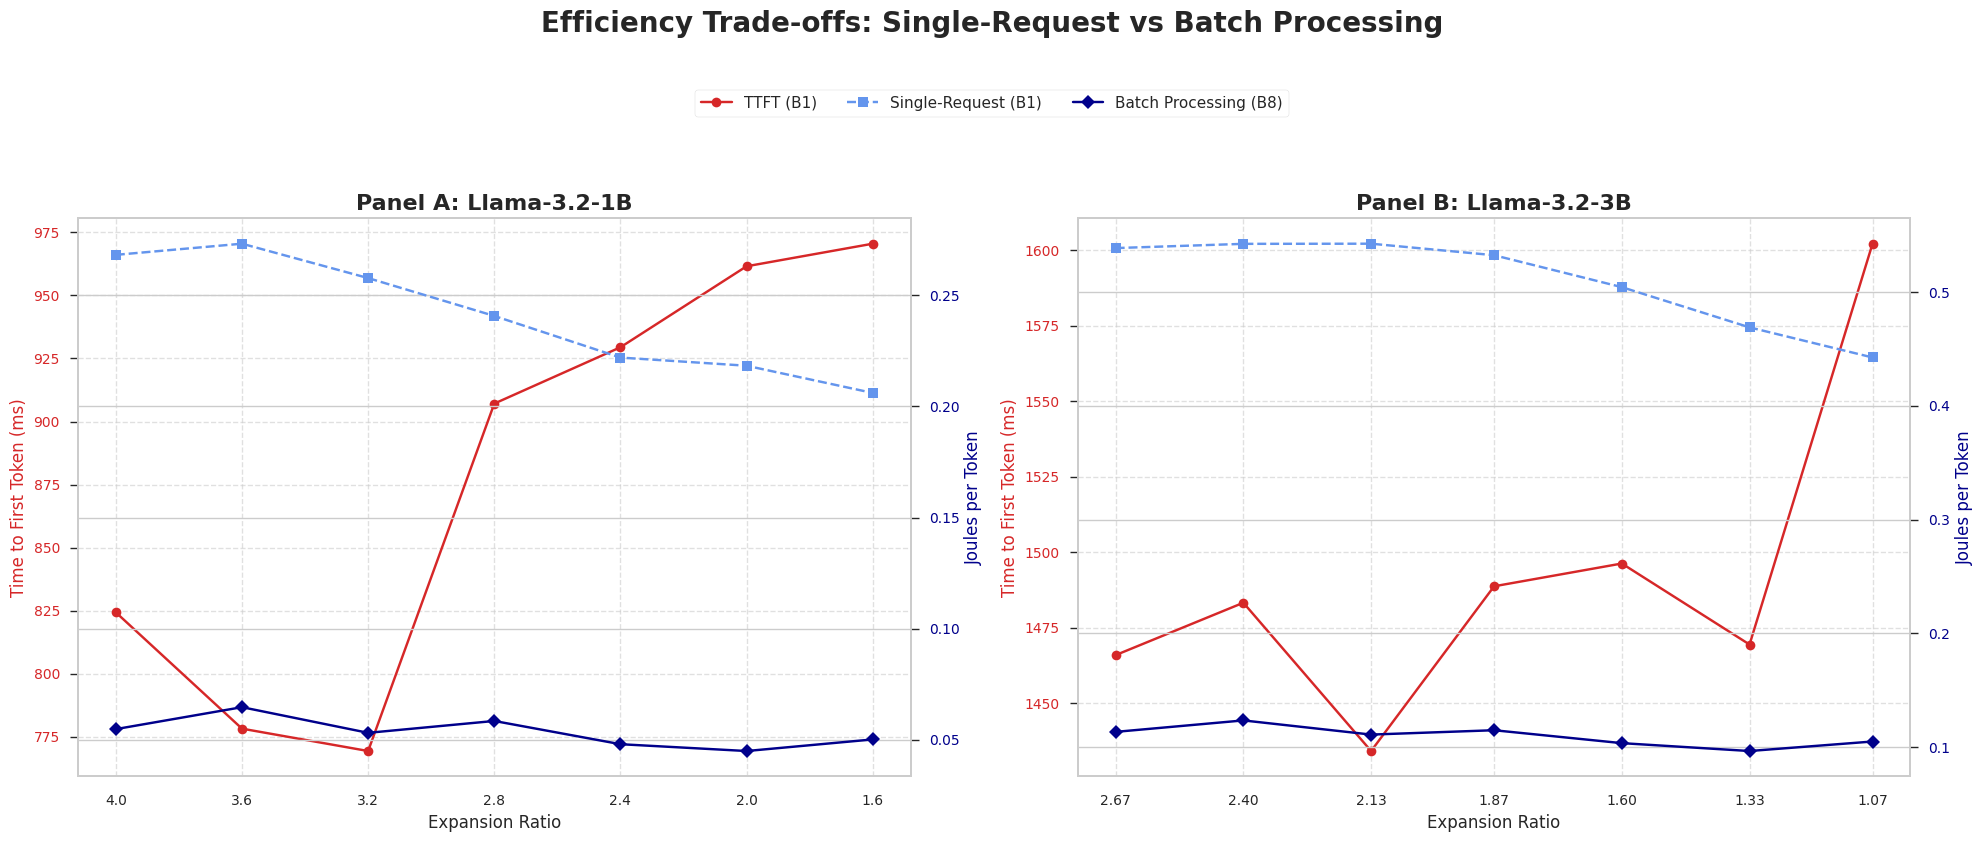

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. Data Extraction and Merging Function ---

def get_merged_carbon_data(model_size_str, carbon_data_dict, perf_data_dict):
    """
    Extracts carbon metrics (TTFT, Joules) and performance metrics
    (expansion_rate) from the two data dictionaries and merges them
    on 'pruning_pct'.
    """

    # 1. Extract Carbon Data
    carbon_data = []
    carbon_dict = carbon_data_dict[model_size_str]
    for model_key, model_vals in carbon_dict.items():
        try:
            carbon_data.append({
                'pruning_pct': model_vals['pruning_pct'],
                # Get TTFT from mmlu_latency_b1 (bsz=1)
                'TTFT_B1': model_vals['results']['mmlu_latency_b1']['ttft_mean'],
                # Get Joules from mmlu_latency_b1 (bsz=1)
                'Joules_B1': model_vals['results']['mmlu_latency_b1']['joules_per_token_mean'],
                # Get Joules from mmlu_throughput_b8 (bsz=8)
                'Joules_B8': model_vals['results']['mmlu_throughput_b8']['joules_per_token_mean']
            })
        except KeyError as e:
            print(f"Warning: Missing carbon data for {model_key} in {model_size_str}: {e}")

    df_c = pd.DataFrame(carbon_data)

    # 2. Extract Expansion Rate Data
    expansion_data = []
    perf_dict = perf_data_dict[model_size_str]
    for model_key, model_vals in perf_dict.items():
        try:
            expansion_data.append({
                'pruning_pct': model_vals['pruning_pct'],
                'expansion_rate': model_vals['expansion_rate']
            })
        except KeyError as e:
            print(f"Warning: Missing performance data for {model_key} in {model_size_str}: {e}")

    df_e = pd.DataFrame(expansion_data)

    # 3. Merge, Sort, and Return
    if df_c.empty or df_e.empty:
        return pd.DataFrame() # Return empty if data is missing

    df_merged = pd.merge(df_c, df_e, on='pruning_pct')
    df_merged = df_merged.sort_values(by='pruning_pct').reset_index(drop=True)
    return df_merged

# --- 2. Load Data for Both Models ---

# Check if all required data variables exist
if ('models_data_carbon' in locals() and
    'models_data' in locals() and
    '1B' in models_data_carbon and
    '3B' in models_data_carbon and
    '1B' in models_data and
    '3B' in models_data):

    df_1b = get_merged_carbon_data('1B', models_data_carbon, models_data)
    df_3b = get_merged_carbon_data('3B', models_data_carbon, models_data)

    # --- 3. Plotting ---

    plt.style.use('seaborn-v0_8-notebook')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    # Define colors
    color_latency = 'tab:red'
    color_joules_b1 = 'cornflowerblue'
    color_joules_b8 = 'darkblue'

    # --- Panel A: Llama-3.2-1B ---

    # Create the twin axis
    ax1_twin = ax1.twinx()

    # Get x-axis ticks
    x_ticks_1b = df_1b['expansion_rate'].tolist()

    # Plot Y1 (Left - Latency)
    # Using 'C3' which is the default for 'tab:red' in this style
    l1 = ax1.plot(df_1b['expansion_rate'], df_1b['TTFT_B1'], color=color_latency,
                  marker='o', linestyle='-', label='TTFT (B1)')
    ax1.set_ylabel('Time to First Token (ms)', color=color_latency, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color_latency)

    # Plot Y2 (Right - Joules)
    l2 = ax1_twin.plot(df_1b['expansion_rate'], df_1b['Joules_B1'], color=color_joules_b1,
                       marker='s', linestyle='--', label='Single-Request (B1)')
    l3 = ax1_twin.plot(df_1b['expansion_rate'], df_1b['Joules_B8'], color=color_joules_b8,
                       marker='D', linestyle='-', label='Batch Processing (B8)')
    ax1_twin.set_ylabel('Joules per Token', color=color_joules_b8, fontsize=12)
    ax1_twin.tick_params(axis='y', labelcolor=color_joules_b8)

    # Common X-axis settings for Panel A
    ax1.set_title('Panel A: Llama-3.2-1B', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Expansion Ratio', fontsize=12)
    ax1.invert_xaxis()
    ax1.set_xticks(x_ticks_1b)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Panel B: Llama-3.2-3B ---

    # Create the twin axis
    ax2_twin = ax2.twinx()

    # Get x-axis ticks
    x_ticks_3b = df_3b['expansion_rate'].tolist()

    # Plot Y1 (Left - Latency)
    ax2.plot(df_3b['expansion_rate'], df_3b['TTFT_B1'], color=color_latency,
             marker='o', linestyle='-', label='TTFT (B1)')
    ax2.set_ylabel('Time to First Token (ms)', color=color_latency, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_latency)

    # Plot Y2 (Right - Joules)
    ax2_twin.plot(df_3b['expansion_rate'], df_3b['Joules_B1'], color=color_joules_b1,
                  marker='s', linestyle='--', label='Single-Request (B1)')
    ax2_twin.plot(df_3b['expansion_rate'], df_3b['Joules_B8'], color=color_joules_b8,
                  marker='D', linestyle='-', label='Batch Processing (B8)')
    ax2_twin.set_ylabel('Joules per Token', color=color_joules_b8, fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor=color_joules_b8)

    # Common X-axis settings for Panel B
    ax2.set_title('Panel B: Llama-3.2-3B', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Expansion Ratio', fontsize=12)
    ax2.invert_xaxis()
    ax2.set_xticks(x_ticks_3b)
    ax2.grid(True, linestyle='--', alpha=0.6)

    # --- Global Settings: Title and Legend ---

    fig.suptitle('Efficiency Trade-offs: Single-Request vs Batch Processing', fontsize=20, y=1.05, fontweight='bold')

    # Create a combined legend
    handles = l1 + l2 + l3
    labels = [h.get_label() for h in handles]
    # Place legend below the title, above the plots
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to make room for legend/title
    plt.savefig('figure_7_efficiency_tradeoffs.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("ERROR: 'models_data_carbon' or 'models_data' not found.")
    print("Please ensure you have successfully run all previous data loading cells.")